In [1]:
import sys
import os
ref_path = r"D:\OneDrive\References\Farahani_ALS-main\codes"  ## https://github.com/netneurolab/Farahani_ALS/tree/main/codes
sys.path.append(ref_path)

import warnings
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from neuromaps.images import load_data
from neuromaps.images import dlabel_to_gifti
from netneurotools.datasets import fetch_schaefer2018
from functions import parcel2fsLR, save_gifti
from globals import path_results, path_sc, nnodes, path_networks,path_networks_ALS
from functions import save_parcellated_data_in_Schaefer_forVis
from scipy.io import loadmat, savemat
#References: https://github.com/netneurolab/Farahani_ALS/tree/2ac249a22d1973f4758a9d6c0968c1d9cc73bebf/codes

In [5]:
#------------------------------------------------------------------------------
# Needed functions
#------------------------------------------------------------------------------

def calculate_average_neighbor_atrophy_SC(SC,disease_profile,th):
     SC[np.eye(nnodes).astype(bool)] = 0
     SC[SC <= th] = 0 # Remove neg values
     num_regions = len(disease_profile)
     average_neighbor_atrophy = np.zeros(num_regions)
     for i in range(nnodes):
         average_neighbor_atrophy[i] = np.nanmean( disease_profile[ (SC[i, :] != 0) ])
     return average_neighbor_atrophy
 
 
def plot_atrophy_vs_average_neighbor(disease_profile, average_neighbor_atrophy,name_to_save=None,xlim=None):
    plt.figure(figsize=(6, 5)) 
    plt.scatter(average_neighbor_atrophy,disease_profile,
                color = 'brown',
                linewidth = 1,
                alpha = 0.35)
    sns.regplot(y=disease_profile,
                x=average_neighbor_atrophy,
                scatter=False,
                truncate=False,color="dimgray",
                line_kws={'linewidth':2})   

    plt.ylabel('regional atrophy')
    plt.xlabel('average neighbor atrophy')
    # Remove NaN values from both vectors
    valid_indices = ~np.isnan(disease_profile) & ~np.isnan(average_neighbor_atrophy)
    cleaned_regional_atrophy = disease_profile[valid_indices]
    cleaned_average_neighbor_atrophy = average_neighbor_atrophy[valid_indices]
    r, p = stats.pearsonr(cleaned_regional_atrophy,
                           cleaned_average_neighbor_atrophy)
    print(r)
    print(p)
    plt.annotate(f'r = {r:.2f}',
                 xy = (0.7, 0.9),
                 xycoords = 'axes fraction')
    plt.tight_layout()
    plt.ylim(-1, 0.7)
    if xlim==1:
        plt.xlim(-0.4, 0.2)
    elif xlim==2:
        plt.xlim(-0.6, 0.3) 
    elif xlim==3:
        plt.xlim(-0.4, 0.17)
    elif xlim==4:
        plt.xlim(-0.47, 0.12)    
    current_dir = os.getcwd()
    if name_to_save:
        plt.savefig(os.path.join(current_dir, name_to_save + '.pdf'),dpi = 300)
                

In [3]:
# Load disease atropy map (W-score map)
tmp  = loadmat('D:\\OneDrive\\5_TMS_response\\CT_Wscore53avg_S400_7Net_vHCP2.mat')
W_score_avg = tmp['Wscore_s400_7Net']
disease_profile = np.reshape(W_score_avg, 400)

include_sc = 1
path_fig='D:\\OneDrive\\5_TMS_response\\Epicenter\\Many_nets\\dataHansenSSC\\'

In [4]:
#Load networks
## https://github.com/netneurolab/hansen_many_networks/tree/085151024a2f8dda1f07ce13e946def1aec93f17/data/Schaefer400
hansen_dir ='D:\\OneDrive\\References\\hansen_many_networks-master\\data\\Schaefer400\\'
sc = np.load(hansen_dir + 'consensusSC.npy')
fc = np.load(hansen_dir + 'haemodynamic_connectivity.npy')

gc = np.load(hansen_dir + 'gene_coexpression.npy')
rs = np.load(hansen_dir + 'receptor_similarity.npy')

networks = {"gene_coexpression"         : gc,
            "receptor_similarity"       : rs,
            "haemodynamic_connectivity" : fc}

0.41803312402223725
2.3761505364581054e-18


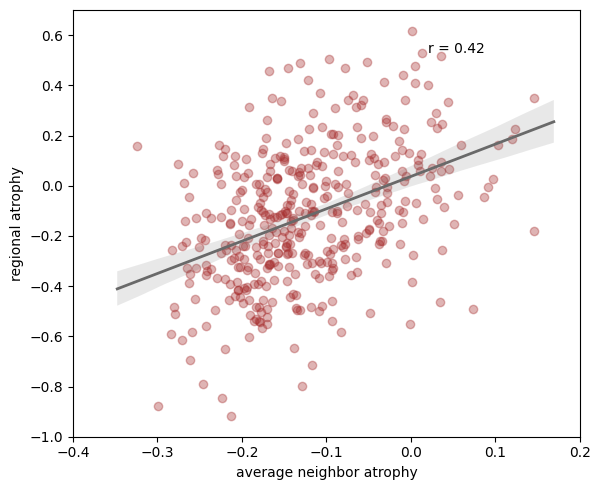

In [6]:
#------------------------------------------------------------------------------
# Calculate atrophy of structurally connected nodes
#------------------------------------------------------------------------------
average_neighbor_atrophy_SC = calculate_average_neighbor_atrophy_SC(sc,disease_profile,0)
savemat('SCinformed_neighbour_abnormality.mat', {'SCinformed':average_neighbor_atrophy_SC})

# Plot the scatter plot of node and neighbour atrophy
plot_atrophy_vs_average_neighbor(disease_profile,
                                 average_neighbor_atrophy_SC,
                                 name_to_save='SCinformed_CT_Wscore53avg_S4007_vHCP2_HansenSSC.pdf',
                                 xlim=1)



In [ ]:
### Viualization the many networks 
for network in networks.keys():
    net_temp = networks[network]
    net_temp = np.arctanh(networks[network]) # Normalization step
    net_temp[np.eye(nnodes).astype(bool)] = 0 # Make diagonal zero
    net_temp[net_temp < 0] = 0 # Remove neg values
    if include_sc == 1:
        net_temp[sc <= 0] = 0 # Filter the network based on sc
    networks[network] = net_temp
    
    if include_sc == 1:
        # Load strucutral conenctome and save the mask as a png file
        if network =="gene_coexpression":
                plt.figure()
                sns.heatmap(sc,
                        cbar=True,
                        vmin= -1* np.std(sc[sc>0]),
                        vmax=  1* np.std(sc[sc>0]),
                        square=True,
                        cmap='coolwarm')
                plt.xticks([])
                plt.yticks([])
                plt.xlabel('')
                plt.ylabel('')
                plt.savefig(path_fig + '\\heatmap_sc_dataHansenSSC.png',
                        bbox_inches = 'tight',
                        dpi = 600,
                        transparent = True)
                plt.show()
    plt.figure(figsize = (8, 8))
    # Std of remaining edges, across edges that actually exist
    sns.heatmap(networks[network],
                vmin= -1* np.std(net_temp[net_temp>0]),
                vmax=  1* np.std(net_temp[net_temp>0]),
                cmap='coolwarm',
                cbar=True,
                square=True)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')

    plt.savefig(path_fig + '\\' + network + '_heatmap_dataHansenSSC.png',
            bbox_inches = 'tight',
            dpi = 600,
            transparent = True)
    plt.show()     

0.5706020997572123
0.5792887028435447


C:\Users\123\AppData\Local\Temp\ipykernel_25636\2697994133.py:12: RuntimeWarning: invalid value encountered in scalar divide
  neighbour_abnormality[i] = np.nansum(temp_disease_profile * net[:,i])/(np.sum(net[:,i]))


0.5287504110411482


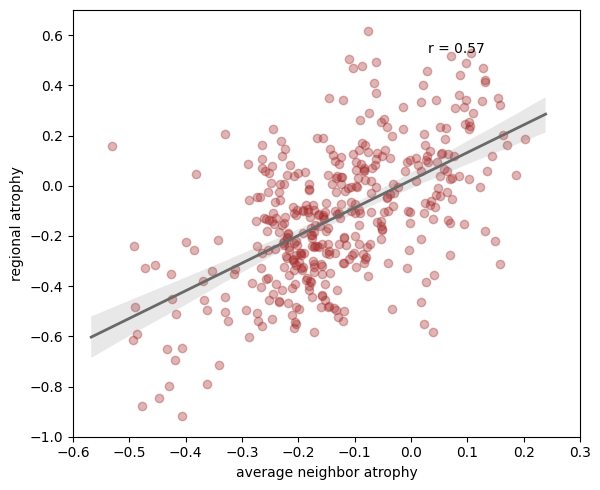

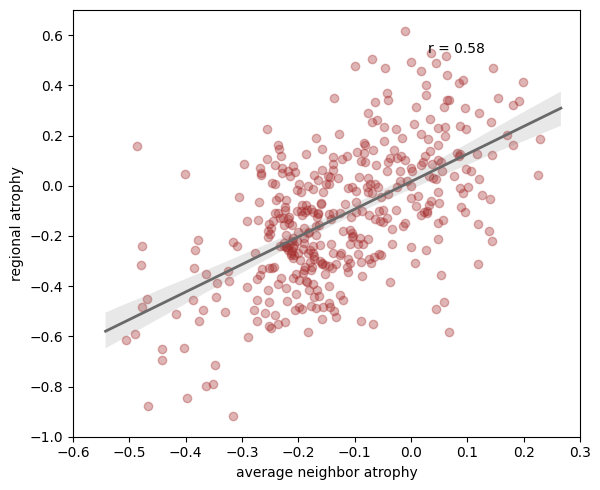

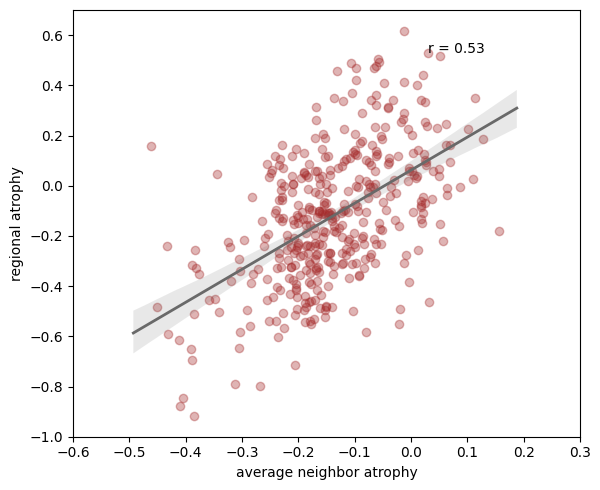

In [7]:
#------------------------------------------------------------------------------
# Plot node-neighbor scatter plot per network
#------------------------------------------------------------------------------
nn_corrs = np.zeros((len(networks.keys()), 2))
all_neighbour_abnormality = {}

for n, network in enumerate(networks.keys()):
    temp_disease_profile = disease_profile # Copy disease pattern into this loop    
    neighbour_abnormality = np.zeros((nnodes,))
    net = networks[network].copy()
    for i in range(nnodes):
         neighbour_abnormality[i] = np.nansum(temp_disease_profile * net[:,i])/(np.sum(net[:,i]))
    # It can happen that there is no count --> which will make nan or inf
    mask = ~np.isnan(neighbour_abnormality)
    neighbour_abnormality[~mask] = 0
    temp_disease_profile[~mask] = 0
    all_neighbour_abnormality[network] = neighbour_abnormality.copy()

    plot_atrophy_vs_average_neighbor(temp_disease_profile,
                                     neighbour_abnormality,
                                     name_to_save= network +'_informed_CT_Wscore53avg_S4007_vHCP2_HansenSSC.pdf',
                                     xlim=2)
savemat('all_neighbour_abnormality.mat', all_neighbour_abnormality)